In [10]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this notebook I try to document the logic/math of using offline-generated re-gridding weights from SCRIP (via CDO) for re-mapping arbitrary 

First we generate regridding weights for a source and target grid. We'll generate weights for both conservative and bilinear remapping, just so we can generalize the logic here a little bit.

In [2]:
dst_gridded_data = "../data/obs.usa_subset.nc"
src_gridded_data = "../data/fgm.REF.1980-2010.ensemble.nc"

!cdo griddes {dst_gridded_data} > dst.grid
!cdo griddes {src_gridded_data} > src.grid

cdo griddes: Processed 6 variables ( 0.02s )
Warning (cdf_scan_var_attr) : NetCDF: Variable not found - time_bnds
cdo griddes: Processed 6 variables ( 0.01s )


In [3]:
!cdo genycon,dst.grid {src_gridded_data} con.weights.nc
!cdo genbil,dst.grid {src_gridded_data} bil.weights.nc

Warning (cdf_scan_var_attr) : NetCDF: Variable not found - time_bnds
cdo genycon: YAC first order conservative weights from lonlat (24x15) to lonlat (24x12) grid
cdo genycon:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo genycon: Processed 360 values from 6 variables over 1 timestep ( 0.02s )
Warning (cdf_scan_var_attr) : NetCDF: Variable not found - time_bnds
cdo genbil: SCRIP bilinear weights from lonlat (24x15) to lonlat (24x12) grid
cdo genbil:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 910cdo genbil: Processed 360 values from 6 variables over 1 timestep ( 0.02s )


Now, with the weights generated, we need to construct a linear algebra formulation to apply the remapping. The SCRIP documentation offers the following Fortran code to apply a first-order conservative remapping:

```Fortran
dst_array = 0.0
select case (normalize_opt)
case (’fracarea’)
do n=1,num_links
dst_array(dst_address(n)) = dst_array(dst_address(n)) +
              remap_matrix(1,n)*src_array(src_address(n))
end do
case (’destarea’)
do n=1,num_links
dst_array(dst_address(n)) = dst_array(dst_address(n)) +
             (remap_matrix(1,n)*src_array(src_address(n)))/
             (dst_frac(dst_address(n)))
end do
case (’none’)
do n=1,num_links
dst_array(dst_address(n)) = dst_array(dst_address(n)) +
             (remap_matrix(1,n)*src_array(src_address(n)))/
       (dst_area(dst_address(n))*dst_frac(dst_address(n)))
end do
end select
```

The problem here is that everything is formulated in terms of a linear vector of locations with lots of explicit indexing. We can re-construct this Python code, using the case where we do not do any normalize operations.

In [97]:
x = src_data.unstack('cell')
x['lat']

<xarray.DataArray 'lat' (lat: 15)>
array([ 23.684211,  25.578947,  27.473684,  29.368421,  31.263158,  33.157895,
        35.052632,  36.947368,  38.842105,  40.736842,  42.631579,  44.526316,
        46.421053,  48.315789,  50.210526])
Coordinates:
    lev      float64 992.6
  * lat      (lat) float64 23.68 25.58 27.47 29.37 31.26 33.16 35.05 36.95 ...

In [98]:
weights

<xarray.Dataset>
Dimensions:              (dst_grid_rank: 2, dst_grid_size: 288, num_links: 624, num_wgts: 1, src_grid_rank: 2, src_grid_size: 360)
Dimensions without coordinates: dst_grid_rank, dst_grid_size, num_links, num_wgts, src_grid_rank, src_grid_size
Data variables:
    src_grid_dims        (src_grid_rank) int32 24 15
    dst_grid_dims        (dst_grid_rank) int32 24 12
    src_grid_center_lat  (src_grid_size) float64 0.4134 0.4134 0.4134 0.4134 ...
    dst_grid_center_lat  (dst_grid_size) float64 0.3927 0.3927 0.3927 0.3927 ...
    src_grid_center_lon  (src_grid_size) float64 4.102 4.145 4.189 4.232 ...
    dst_grid_center_lon  (dst_grid_size) float64 4.102 4.145 4.189 4.232 ...
    src_grid_imask       (src_grid_size) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    dst_grid_imask       (dst_grid_size) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    src_grid_area        (src_grid_size) float64 0.002371 0.002371 0.002371 ...
    dst_grid_area        (dst_grid_size) float64 0.001759 0.

In [80]:
import numpy as np
import xarray as xr

field = 'U'
src_data = xr.open_dataset(src_gridded_data)[field]
src_data = src_data.stack(cell=['lat', 'lon'])

# Stacking always produces the trailing dimension in a dataset
src_array = src_data.values
leading_shape, n_cells_src = src_array.shape[:-1], src_array.shape[-1]

weights = xr.open_dataset("con.weights.nc")
n_cells_dst = len(weights.dst_grid_center_lat)
dst_array = np.empty(list(leading_shape) + [n_cells_dst, ])

num_links = len(weights.src_address)
dst_address = weights.dst_address.values - 1
src_address = weights.src_address.values - 1
remap_matrix = weights.remap_matrix.values
# dst_area = weights.dst_grid_area.values
# dst_frac = weights.dst_grid_frac.values

for n in range(num_links):
    dst_addr, src_addr = dst_address[n], src_address[n]
    dst_array[:, dst_addr] += (remap_matrix[n]*src_array[:, src_addr])#/(dst_area[dst_addr]*dst_frac[dst_addr])

In [93]:
from darpy import copy_attrs, append_history
append_history?

Re-package the data.

In [65]:
template = xr.open_dataset(dst_gridded_data)[['lon', 'lat']].copy()
template['time'] = src_data['time']
tgt_stacked = tgt.stack(cell=['lat', 'lon'])
tgt_stacked[field] = (('cell', ), dst_array)
tgt = tgt_stacked.unstack('cell')

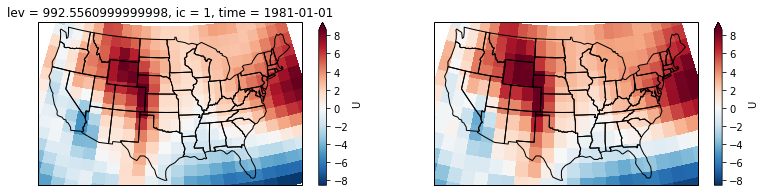

In [66]:
from darpy.plot import multipanel_figure, PROJECTION, infer_cmap_params
from stat_pm25.plot import STATE_PROJ, add_usa_states

fig, axs = multipanel_figure(1, 2, aspect=2, projection=STATE_PROJ)
axs = axs.ravel()

cmap_params = infer_cmap_params(tgt[field])
del cmap_params['cnorm']
del cmap_params['levels']
kws = dict(cmap='spectral', transform=PROJECTION, infer_intervals=True)
kws.update(cmap_params)

src_data.isel(time=0).plot.pcolormesh('lon', 'lat', ax=axs[0],**kws)
tgt[field].plot.pcolormesh('lon', 'lat', ax=axs[1], **kws)
for ax in axs:
    _ = add_usa_states(ax, facecolor='None')

In [128]:
isinstance('s', str)

True

In [119]:
from stat_pm25.regrid import remap_dataset

x = remap_dataset(xr.open_dataset("../data/fgm.all_cases.usa_subset.nc"),
              xr.open_dataset(dst_gridded_data),
              weights)

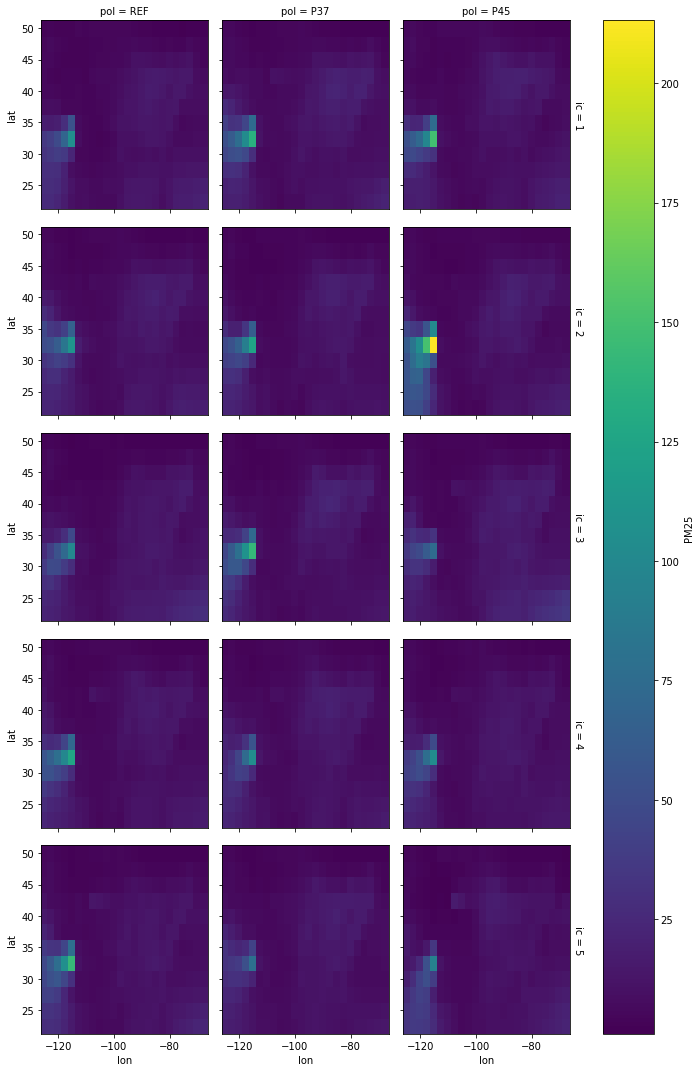

In [126]:
x['PM25'].isel(time=0, dec=2).plot.pcolormesh('lon', 'lat', col='pol', row='ic', infer_intervals=True)